# BLG641E- Medical Image Computing

## Coursework - Age regression from brain MRI

Predicting the age from a brain MRI scan is believed to have diagnostic value in the context of a number of pathologies that cause structural changes and damage to the brain. Assuming an accurate predictor of brain age can be trained based on a set of healthy subjects, the idea is then to compare the predicted age obtained on a new patient scan with the real age of that patient. Discrepancy between predicted and real age might indicate the presence of pathology and abnormal changes to the brain.

The objective for the coursework is to implement two different supervised learning approaches for age regression from brain MRI data. Data from 652 subjects will be provided. Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are dedicated sections in the Jupyter notebook for each approach which contain some detailed instructions and some hints and notes.

For many tasks, you will find useful ideas and implementations in the tutorial notebooks. Make sure to add documentation to your code. Markers will find it easier to understand your reasoning when sufficiently detailed comments are provided in your implementations.

#### Read the descriptions and provided code cells carefully and look out for the cells marked with 'TASK'.

In [1]:
# Use full browser width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Getting started

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the population of 652 subjects. Let's start by loading the meta data, that is the data containing information about the subject IDs, their age, and gender.

In [2]:
# Read the meta data using pandas
import pandas as pd

data_dir = '/home/burakk/Projects/itu-mic/data/'

meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look the the population statistics.

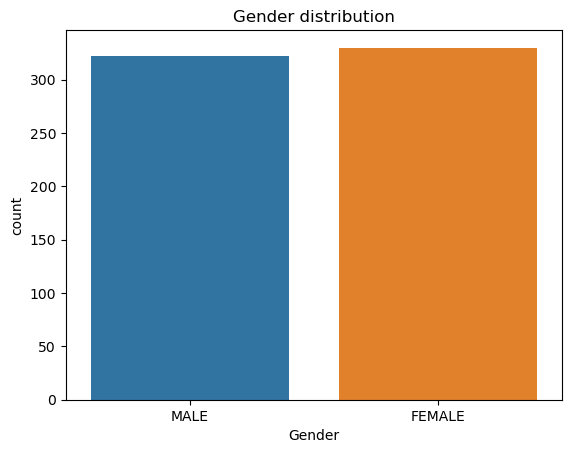

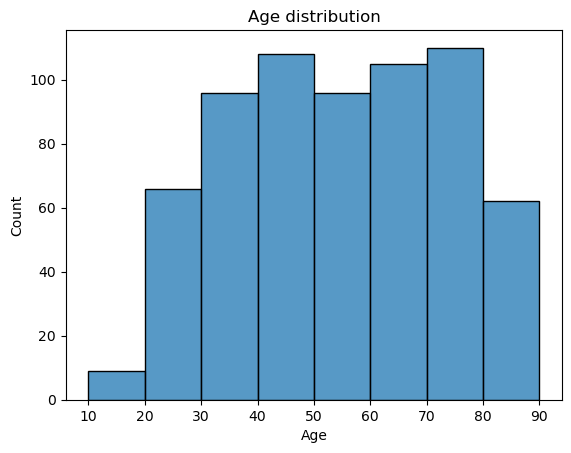

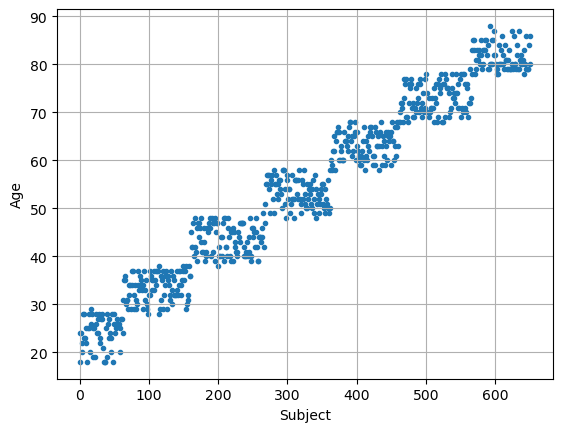

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="gender_text", data=meta_data) # sns.countplot is replaced by sns.histplot since version 0.11.0
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.histplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90]) # sns.distplot is replaced by sns.histplot since version 0.11.0
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up the image viewer

In [3]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)))

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

/home/burakk/Projects/itu-mic/data/images/msub-CC110033_T1w_rigid_to_mni.nii.gz
Imaging data of subject CC110033 with age 24

MR Image (used in part A)


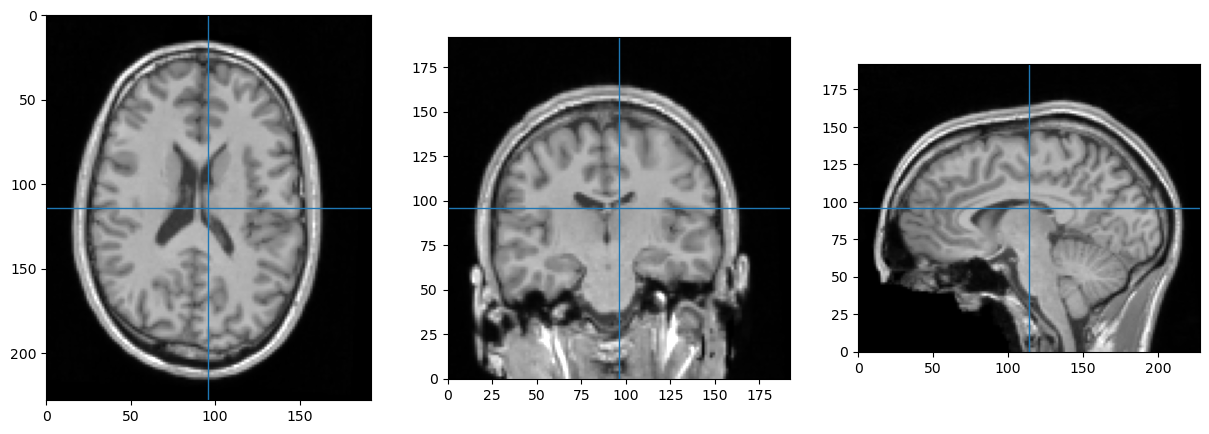

Brain mask (used in part A)


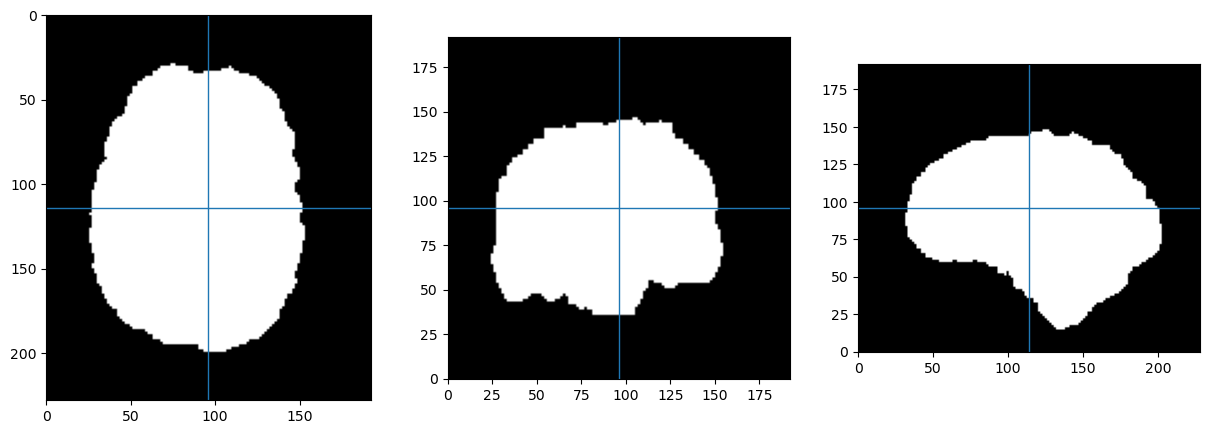

Spatially normalised grey matter maps (used in part B)


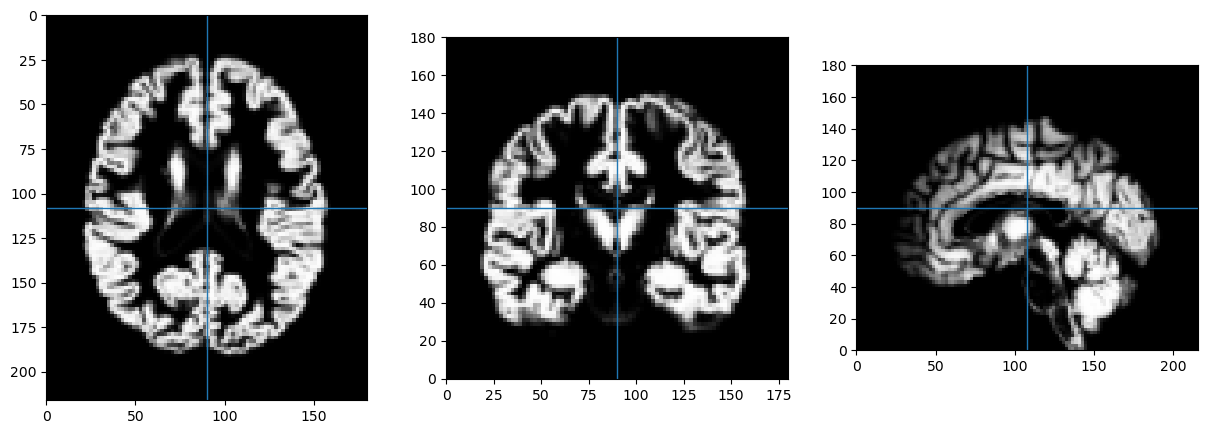

In [4]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'graymaps/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
print(image_filename)
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject from the volumes of brain tissues, including grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume might decrease. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a three-class brain tissue segmentation needs to be implemented and applied to the provided 652 brain scans. Brain masks are provided which have been generated with a state-of-the-art brain extraction tool from the FSL toolkit.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a hypothesis with higher order polynomials? How about other regression methods such as support vector regression or regression trees? The accuracy of different methods should be evaluated using cross-validation, and average prediction accuracy should be reported.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B only.

### TASK A-1: Brain tissue segmentation

Implement a brain tissue segmentation method which provides segmentations of GM, WM, and CSF. Apply this method to all 652 MR images, and calculate the three tissue volumes for each subject.

*Hint:* For the segmentation method, you may want to make use of the provided brain masks to constrain your segmentation to brain voxels (compare tutorial 3).

*Note:* For more efficient experimentation, you may want to initially restrict computations to the first five or so images. Once you're happy with the segmentation results, apply the method to all 652 images (which may take a while to run). You may also want to save the registration results using `sitk.WriteImage`, so you don't have to run the segmentation each time from scratch but instead load the stored results.

In [6]:
import glob
import SimpleITK as sitk

def segment(image, mask):
    # Apply intensity thresholds for each tissue
    gm_threshold_lower = 1
    gm_threshold_upper = 100
    wm_threshold_lower = 101
    wm_threshold_upper = 200
    csf_threshold_lower = 201
    csf_threshold_upper = 300

    # Segment gray matter
    gm_mask = sitk.BinaryThreshold(image, gm_threshold_lower, gm_threshold_upper, 1, 0)

    # Segment white matter
    wm_mask = sitk.BinaryThreshold(image, wm_threshold_lower, wm_threshold_upper, 1, 0)

    # Segment cerebrospinal fluid
    csf_mask = sitk.BinaryThreshold(image, csf_threshold_lower, csf_threshold_upper, 1, 0)
    
    """
    # Also consider using morphological operations to improve the segmentation results
    
    lower_threshold, upper_threshold = 100, 200 # Thresholds for gray matter
    gm_image = sitk.BinaryThreshold(image, lower_threshold, upper_threshold, 1, 0)
    closing_radius = (2, 2, 2)  # Radius of the closing operation in each dimension
    gm_image = sitk.BinaryMorphologicalClosing(gm_image, closing_radius)
    erosion_radius = (1, 1, 1)  # Radius of the erosion operation in each dimension
    gm_image = sitk.BinaryErode(gm_image, erosion_radius)
    """
    
    # Apply the provided brain mask to constrain the segmentations
    gm_mask = sitk.And(gm_mask, mask)
    wm_mask = sitk.And(wm_mask, mask)
    csf_mask = sitk.And(csf_mask, mask)

    return gm_mask, wm_mask, csf_mask

def kafka(output_dir, img):
    outputImageFileName = output_dir + image_filenames[i].split('/')[-1]
    writer = sitk.ImageFileWriter()
    writer.SetFileName(outputImageFileName)
    writer.Execute(img)

data_dir = '/home/burakk/Projects/itu-mic/data/'

image_dir = data_dir + "images/" 
image_filenames = sorted(glob.glob(image_dir + '*.nii.gz'))

mask_dir = data_dir + "masks/" 
mask_filenames = sorted(glob.glob(mask_dir + '*.nii.gz'))

masked_output_dir = data_dir + "o_masked/"
gm_output_dir = data_dir + "o_gm/"
wm_output_dir = data_dir + "o_wm/"
csf_output_dir = data_dir + "o_csf/"

# image_filenames = image_filenames[:5]
# mask_filenames = mask_filenames[:5]

for i in range(len(image_filenames)):
    image = sitk.ReadImage(image_filenames[i])
    mask = sitk.ReadImage(mask_filenames[i])
    
    masked_image = sitk.Mask(image, mask)
    kafka(masked_output_dir, masked_image)
    
    gm_mask, wm_mask, csf_mask = segment(image, mask)
    
    kafka(gm_output_dir, gm_mask)
    kafka(wm_output_dir, wm_mask)
    kafka(csf_output_dir, csf_mask)


##### Display a random sample

Masked image: /home/burakk/Projects/itu-mic/data/o_masked/msub-CC120727_T1w_rigid_to_mni.nii.gz


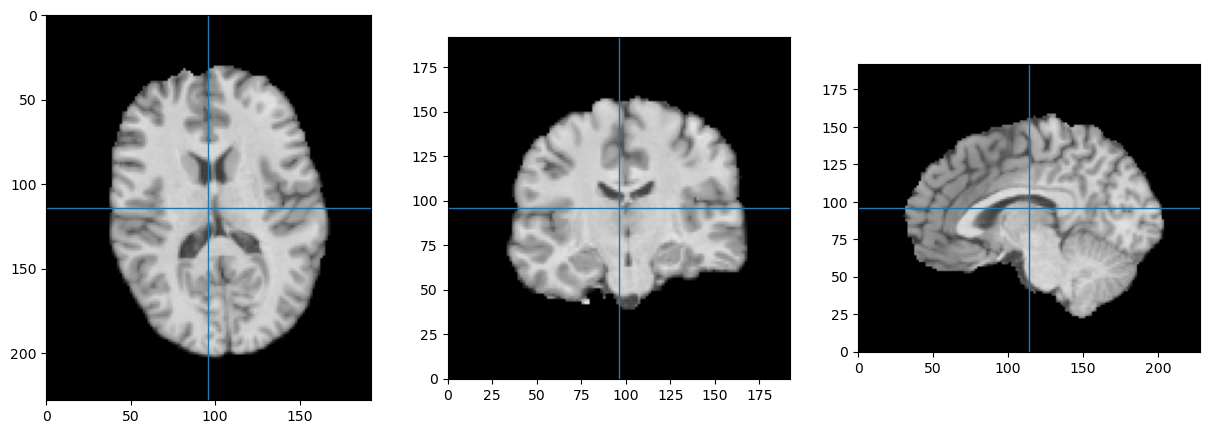

Gray matter mask: /home/burakk/Projects/itu-mic/data/o_gm/msub-CC120727_T1w_rigid_to_mni.nii.gz


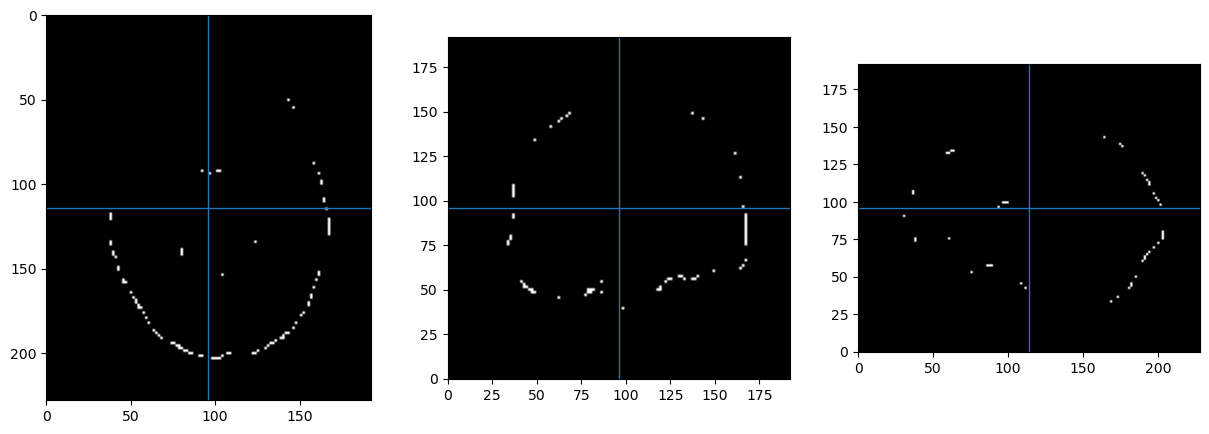

White matter mask: /home/burakk/Projects/itu-mic/data/o_wm/msub-CC120727_T1w_rigid_to_mni.nii.gz


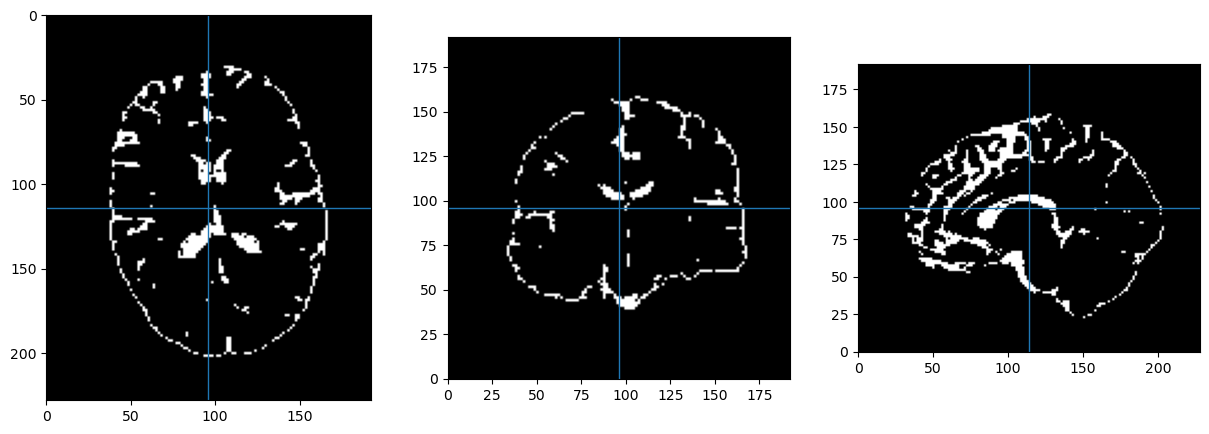

Cerebrospinal fluid mask: /home/burakk/Projects/itu-mic/data/o_csf/msub-CC120727_T1w_rigid_to_mni.nii.gz


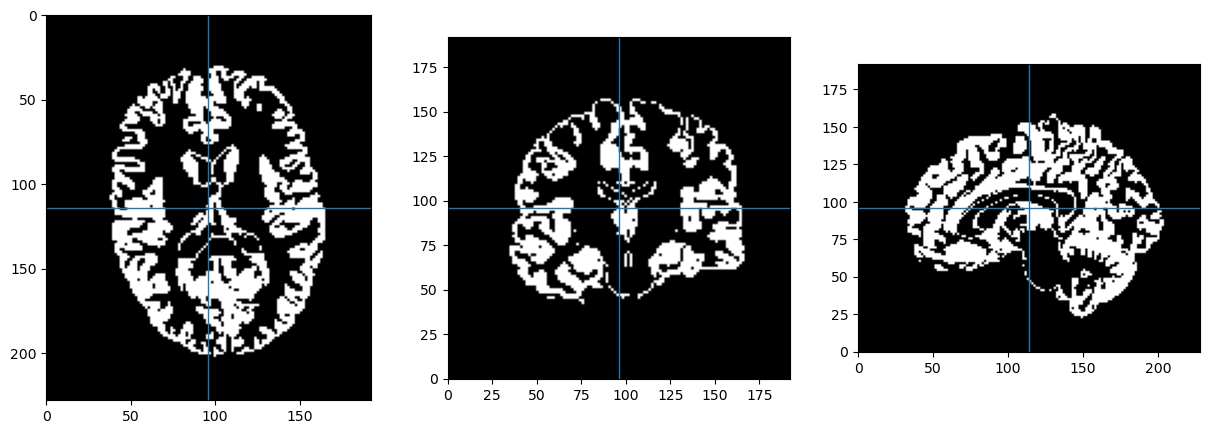

In [5]:
import glob
import SimpleITK as sitk

data_dir = '/home/burakk/Projects/itu-mic/data/'

masked_output_dir = data_dir + "o_masked/"
gm_output_dir = data_dir + "o_gm/"
wm_output_dir = data_dir + "o_wm/"
csf_output_dir = data_dir + "o_csf/"

masked_filenames = sorted(glob.glob(masked_output_dir + '*.nii.gz'))
gm_filenames = sorted(glob.glob(gm_output_dir + '*.nii.gz'))
wm_filenames = sorted(glob.glob(wm_output_dir + '*.nii.gz'))
csf_filenames = sorted(glob.glob(csf_output_dir + '*.nii.gz'))

random_state = 42

img = sitk.ReadImage(masked_filenames[random_state])
print('Masked image:', masked_filenames[random_state])
display_image(img)

img = sitk.ReadImage(gm_filenames[random_state])
print('Gray matter mask:', gm_filenames[random_state])
display_image(img)

img = sitk.ReadImage(wm_filenames[random_state])
print('White matter mask:', wm_filenames[random_state])
display_image(img)

img = sitk.ReadImage(csf_filenames[random_state])
print('Cerebrospinal fluid mask:', csf_filenames[random_state])
display_image(img)

### TASK A-2: Feature calculation

Implement a function that calculates volume features given the three tissue volumes and the overal brain volume (which can be calculated from the brain masks). You should use this function to construct a big matrix $X$ with a row for each subject and features across the columns.

*Note:* You may need to experiment here what the best set of features is. Start with just calculating three simple features of relative tissue volumes. So you should initially construct an $X^{652 \times 3}$.

In [6]:

import numpy as np

data_dir = '/home/burakk/Projects/itu-mic/data/'

masked_output_dir = data_dir + "o_masked/"
mask_filenames = sorted(glob.glob(masked_output_dir + '*.nii.gz'))

gm_output_dir = data_dir + "o_gm/"
gm_filenames = sorted(glob.glob(gm_output_dir + '*.nii.gz'))

wm_output_dir = data_dir + "o_wm/"
wm_filenames = sorted(glob.glob(wm_output_dir + '*.nii.gz'))

csf_output_dir = data_dir + "o_csf/"
csf_filenames = sorted(glob.glob(csf_output_dir + '*.nii.gz'))


def calculate_volume_features(gm, wm, csf, brain):
    # Calculate relative tissue volumes
    relative_gm_volumes = [a/b for a, b in zip(brain, gm)]
    relative_wm_volumes = [a/b for a, b in zip(brain, wm)] 
    relative_csf_volumes = [a/b for a, b in zip(brain, csf)]
    
    # Construct the feature matrix
    X = np.column_stack((relative_gm_volumes, relative_wm_volumes, relative_csf_volumes))
    
    return X

def calculate_brain_volumes(filenames):
    brain_volumes = []
    for filename in filenames:
        # Read the mask image
        mask = sitk.ReadImage(filename)
        
        # Calculate the voxel size
        voxel_size = mask.GetSpacing()
        
        # Calculate the number of voxels in the brain
        num_brain_voxels = sitk.GetArrayFromImage(mask).sum()
        
        # Calculate the brain volume in mm^3
        brain_volume = num_brain_voxels * voxel_size[0] * voxel_size[1] * voxel_size[2]
        
        brain_volumes.append(brain_volume)
    
    return brain_volumes

# Calculate brain volumes
brain_volumes = calculate_brain_volumes(mask_filenames)
gm_volumes = calculate_brain_volumes(gm_filenames)
wm_volumes = calculate_brain_volumes(wm_filenames)
csf_volumes = calculate_brain_volumes(csf_filenames)

print("Brain volumes:", brain_volumes)
print("Gray matter volumes:", gm_volumes)
print("White matter volumes:", wm_volumes)  
print("Cerebrospinal fluid volumes:", csf_volumes)

# Calculate volume features
X = calculate_volume_features(gm_volumes, wm_volumes, csf_volumes, brain_volumes)

print("Shape of X:", X.shape)


Brain volumes: [311029632.0, 271542618.0, 280699587.0, 308623338.0, 416400102.0, 293640687.0, 299909979.0, 278986815.0, 390547980.0, 388184373.0, 210049956.0, 383241726.0, 285761169.0, 444077883.0, 418825296.0, 450291879.0, 335295693.0, 386416602.0, 371744775.0, 326688444.0, 271830087.0, 264065967.0, 283390434.0, 369997524.0, 520280442.0, 402323868.0, 261826965.0, 268199991.0, 411517530.0, 306757449.0, 265725252.0, 328337874.0, 316461600.0, 288580401.0, 259665561.0, 263440431.0, 367346610.0, 282094515.0, 404044119.0, 281774781.0, 351616842.0, 378826767.0, 406503090.0, 408289653.0, 259454583.0, 232765596.0, 250473546.0, 340350498.0, 388388628.0, 309407580.0, 307087011.0, 158921176.5, 299164671.0, 215989443.0, 278064765.0, 325853307.0, 327210003.0, 342933804.0, 449718885.0, 346895946.0, 331725402.0, 369036891.0, 305120763.0, 263856474.0, 230227245.0, 285359895.0, 244408590.0, 261643959.0, 290143107.0, 258445053.0, 319976460.0, 325232307.0, 296413263.0, 339138252.0, 259569117.0, 353401434

/tmp/ipykernel_1606059/1227537571.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  relative_csf_volumes = [a/b for a, b in zip(brain, csf)]


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 652 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least two different regression methods.

*Hint:* This [scikit-learn example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html#sphx-glr-auto-examples-plot-cv-predict-py) might be useful.

##### Preprocessing

In [7]:
import numpy as np

def find_infinite_indices(array):
    infinite_indices = np.where(np.isinf(array))
    return infinite_indices

find_infinite_indices(X)

(array([203]), array([2]))

In [8]:
X[203][2] = 10000000.0
y = meta_data['age']

#### Linear Methods

##### Linear Regression

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Linear regression
model_lr_11 = LinearRegression().fit(X, y)
y_pred_lr_11 = cross_val_predict(model_lr_11, X, y, cv=2)
y_scores_lr_11 = cross_val_score(model_lr_11, X, y, cv=2)

print("Scores:", y_scores_lr_11.mean())


Scores: -7.89091988953661


##### Definining Plot Function for "Age vs Predicted Ages"

In [12]:
def vs_plots(y_pred, ModelName="ModelName"):
    import matplotlib.pyplot as plt
    from sklearn.metrics import PredictionErrorDisplay

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle(f"Cross-validated predictions for {ModelName}")
    plt.tight_layout()
    plt.show()
    

In [ ]:
vs_plots(y_pred=y_pred_lr_11, ModelName="Linear Regression")

##### Lasso Regression

In [10]:
# Alpha = 0.01
model_lasso_11 = Lasso(alpha=0.01).fit(X, y)
y_pred_lasso_11 = cross_val_predict(model_lasso_11, X, y, cv=2)
y_scores_lasso_11 = cross_val_score(model_lasso_11, X, y, cv=2)

print("Scores:", y_scores_lasso_11.mean())

# Alpha = 0.1
model_lasso_12 = Lasso(alpha=0.1).fit(X, y)
y_pred_lasso_12 = cross_val_predict(model_lasso_12, X, y, cv=2)
y_scores_lasso_12 = cross_val_score(model_lasso_12, X, y, cv=2)

print("Scores:", y_scores_lasso_12.mean())

# Alpha = 10
model_lasso_13 = Lasso(alpha=10).fit(X, y)
y_pred_lasso_13 = cross_val_predict(model_lasso_13, X, y, cv=2)
y_scores_lasso_13 = cross_val_score(model_lasso_13, X, y, cv=2)

print("Scores:", y_scores_lasso_13.mean())

# Alpha = 100
model_lasso_14 = Lasso(alpha=10).fit(X, y)
y_pred_lasso_14 = cross_val_predict(model_lasso_14, X, y, cv=2)
y_scores_lasso_14 = cross_val_score(model_lasso_14, X, y, cv=2)

print("Scores:", y_scores_lasso_14.mean())


Scores: -7.8909298013678875
Scores: -7.8910190412752685
Scores: -7.901047724396906
Scores: -7.901047724396906


In [ ]:
vs_plots(y_pred=y_pred_lasso_11, ModelName="Lasso Regression (alpha=0.01)")
vs_plots(y_pred=y_pred_lasso_12, ModelName="Lasso Regression (alpha=0.1)")
vs_plots(y_pred=y_pred_lasso_13, ModelName="Lasso Regression (alpha=10)")
vs_plots(y_pred=y_pred_lasso_14, ModelName="Lasso Regression (alpha=100)")

##### Ridge Regression

In [11]:
# Alpha = 0.01
model_ridge_11 = Ridge(alpha=0.01).fit(X, y)
y_pred_ridge_11 = cross_val_predict(model_ridge_11, X, y, cv=2)
y_scores_ridge_11 = cross_val_score(model_ridge_11, X, y, cv=2)

print("Scores:", y_scores_ridge_11.mean())

# Alpha = 0.1
model_ridge_12 = Lasso(alpha=0.1).fit(X, y)
y_pred_ridge_12 = cross_val_predict(model_ridge_12, X, y, cv=2)
y_scores_ridge_12 = cross_val_score(model_ridge_12, X, y, cv=2)

print("Scores:", y_scores_ridge_12.mean())

# Alpha = 10
model_ridge_13 = Lasso(alpha=10).fit(X, y)
y_pred_ridge_13 = cross_val_predict(model_ridge_13, X, y, cv=2)
y_scores_ridge_13 = cross_val_score(model_ridge_13, X, y, cv=2)

print("Scores:", y_scores_ridge_13.mean())

# Alpha = 100
model_ridge_14 = Lasso(alpha=10).fit(X, y)
y_pred_ridge_14 = cross_val_predict(model_ridge_14, X, y, cv=2)
y_scores_ridge_14 = cross_val_score(model_ridge_14, X, y, cv=2)

print("Scores:", y_scores_ridge_14.mean())


Scores: -7.890919889692983
Scores: -7.8910190412752685
Scores: -7.901047724396906
Scores: -7.901047724396906


In [ ]:
vs_plots(y_pred=y_pred_ridge_11, ModelName="Ridge Regression (alpha=0.01)")
vs_plots(y_pred=y_pred_ridge_12, ModelName="Ridge Regression (alpha=0.1)")
vs_plots(y_pred=y_pred_ridge_13, ModelName="Ridge Regression (alpha=10)")
vs_plots(y_pred=y_pred_ridge_14, ModelName="Ridge Regression (alpha=100)")

#### Support Vector Regressor

In [1]:
from sklearn.svm import SVR

model_svr_11 = SVR(kernel='linear', C=1, gamma='auto').fit(X, y)
y_pred_svr_11 = cross_val_predict(model_svr_11, X, y, cv=2)
y_scores_svr_11 = cross_val_score(model_svr_11, X, y, cv=2)

print("Scores:", y_scores_svr_11.mean())

NameError: name 'X' is not defined

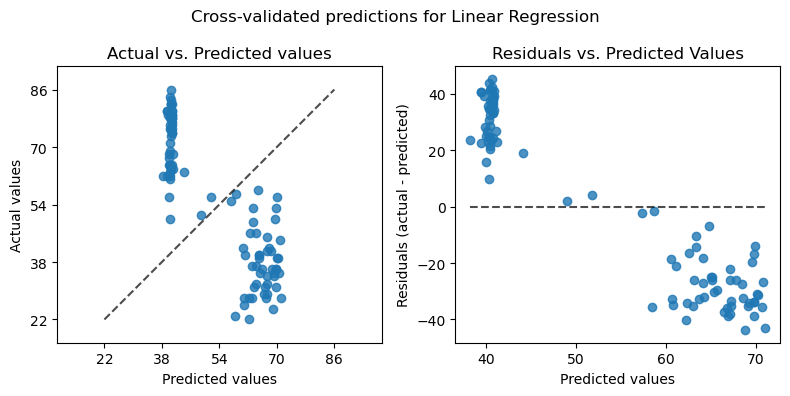

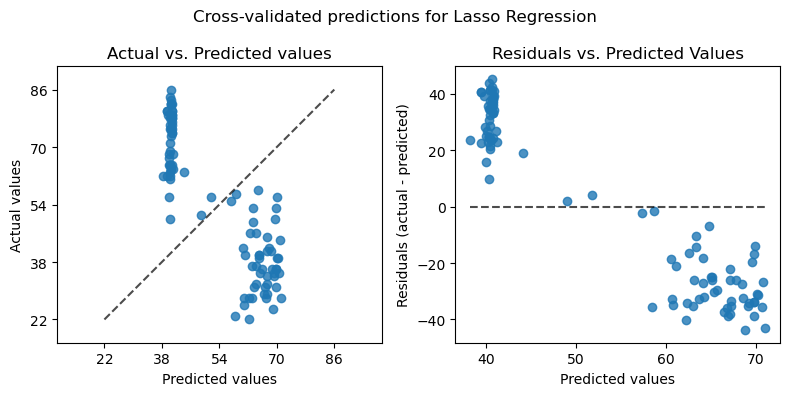

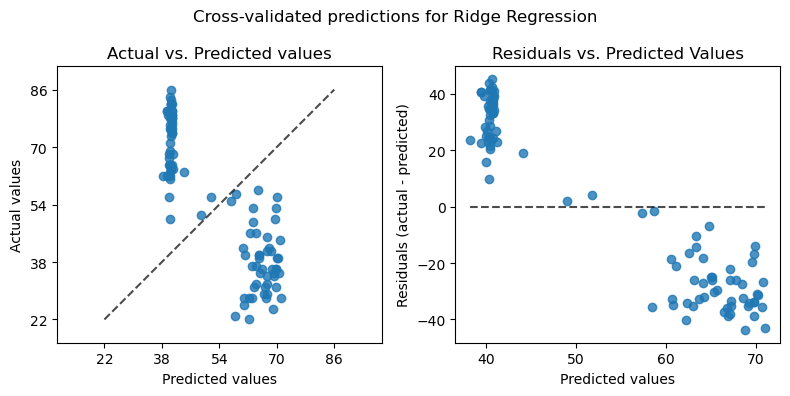

In [13]:
vs_plots(y_pred=y_pred_svr_11, ModelName="SVR")

## /tmp

##### Dividing Dataset [Right in Two](https://youtu.be/6E1DkgUNfBc).

In [75]:
from sklearn.model_selection import train_test_split

# 0.5 means right in two, 42 is the answer to everything
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=42)

X_1.shape, y_1.shape, X_2.shape, y_2.shape


((326, 3), (326,), (326, 3), (326,))

#### Linear Regression #1

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

model_lr_1 = LinearRegression().fit(X_1, y_1)
model_lr_1.score(X_2, y_2)

y_pred_lr_1 = cross_val_predict(model_lr_1, X_2, y_2, cv=2)

for i, j in zip(y_2, y_pred_lr_1):
    print(i, j)


80 54.34441711649161
49 46.93732658621328
44 54.25081053639821
47 58.05800319272819
34 53.253954299923194
69 57.26933488435372
62 50.70629461123912
31 57.61916310849302
74 60.83829104556471
79 59.98679125609326
49 59.391552581474755
79 58.57521590904567
66 60.388296719400174
29 51.047617861161726
70 57.76659424016571
51 46.84746725825833
79 60.77233667039454
85 56.56998494542664
31 52.5234047015609
25 54.57120141251289
83 61.23805240522513
31 54.73005044728679
53 45.57682119320669
27 54.363559700632386
71 60.83383817864463
55 53.89846179493309
40 51.110459138882135
63 60.27642898759732
83 59.510556750299045
27 39.27048631417776
39 58.09945850344424
26 49.42744114135066
46 48.410688439889846
79 60.90391268898021
71 60.95672296516005
48 53.155716239267036
34 56.521532981250125
39 58.11934016361622
42 37.428421891155764
38 50.247765964917
40 46.00287421423357
54 59.22480291121847
44 59.27842719515685
34 55.46124595964804
65 58.335899555639685
24 52.51803067191369
80 61.184142988065375
83 

In [109]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_lr_1, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-15.36 accuracy with a standard deviation of 10.74


In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

model_lr_1 = LinearRegression()

y_pred_lr_1 = cross_val_predict(model_lr_1, X_2, y_2, cv=2)

for i, j in zip(y_2, y_pred_lr_1):
    print(i, j)

80 54.34441711649161
49 46.93732658621328
44 54.25081053639821
47 58.05800319272819
34 53.253954299923194
69 57.26933488435372
62 50.70629461123912
31 57.61916310849302
74 60.83829104556471
79 59.98679125609326
49 59.391552581474755
79 58.57521590904567
66 60.388296719400174
29 51.047617861161726
70 57.76659424016571
51 46.84746725825833
79 60.77233667039454
85 56.56998494542664
31 52.5234047015609
25 54.57120141251289
83 61.23805240522513
31 54.73005044728679
53 45.57682119320669
27 54.363559700632386
71 60.83383817864463
55 53.89846179493309
40 51.110459138882135
63 60.27642898759732
83 59.510556750299045
27 39.27048631417776
39 58.09945850344424
26 49.42744114135066
46 48.410688439889846
79 60.90391268898021
71 60.95672296516005
48 53.155716239267036
34 56.521532981250125
39 58.11934016361622
42 37.428421891155764
38 50.247765964917
40 46.00287421423357
54 59.22480291121847
44 59.27842719515685
34 55.46124595964804
65 58.335899555639685
24 52.51803067191369
80 61.184142988065375
83 

##### Metrics

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_1, y_pred_lr_1)
mse = mean_squared_error(y_1, y_pred_lr_1)
rmse = np.sqrt(mse)
r2 = r2_score(y_1, y_pred_lr_1)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Calculate the average cross-validated score
scores_lr_1 = cross_val_score(model_lr_1, X_1, y_1, cv=2)
average_score = np.mean(scores_lr_1)

# Print the cross-validated scores
print("Cross-validated Scores:", scores_lr_1)
print("Average Score:", average_score)


Mean Absolute Error: 18.119932351115466
Mean Squared Error: 485.505527330076
Root Mean Squared Error: 22.03418996310225
R-squared Score: -0.43231357427764117
Cross-validated Scores: [0.22145536 0.23064902]
Average Score: 0.22605218974524488


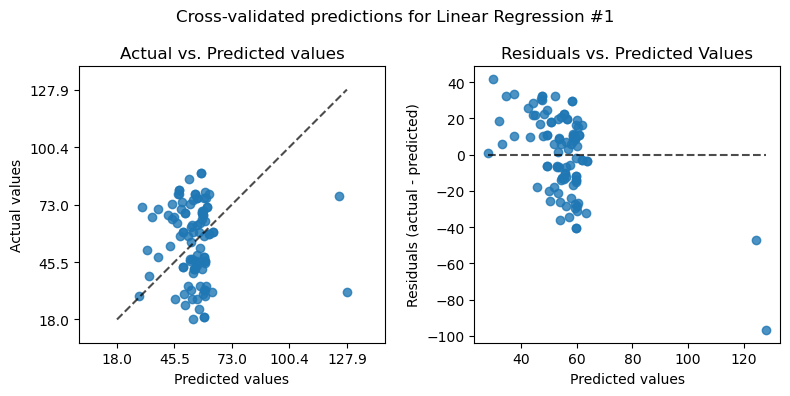

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y_pred_lr_1,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y_pred_lr_1,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for Linear Regression #1")
plt.tight_layout()
plt.show()

#### Linear Regression #2

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

model_lr_2 = LinearRegression()

y_pred_lr_2 = cross_val_predict(model_lr_2, X_2, y_2, cv=2)

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_2, y_pred_lr_2)
mse = mean_squared_error(y_2, y_pred_lr_2)
rmse = np.sqrt(mse)
r2 = r2_score(y_2, y_pred_lr_2)

# Print the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Calculate the average cross-validated score
scores_lr_2 = cross_val_score(model_lr_2, X_2, y_2, cv=2)
average_score = np.mean(scores_lr_2)

# Print the cross-validated scores
print("Cross-validated Scores:", scores_lr_2)
print("Average Score:", average_score)


Mean Absolute Error: 14.16721220260423
Mean Squared Error: 300.30210289801545
Root Mean Squared Error: 17.329226840745534
R-squared Score: 0.13772422376608462
Cross-validated Scores: [0.1899911  0.08782857]
Average Score: 0.1389098338427821


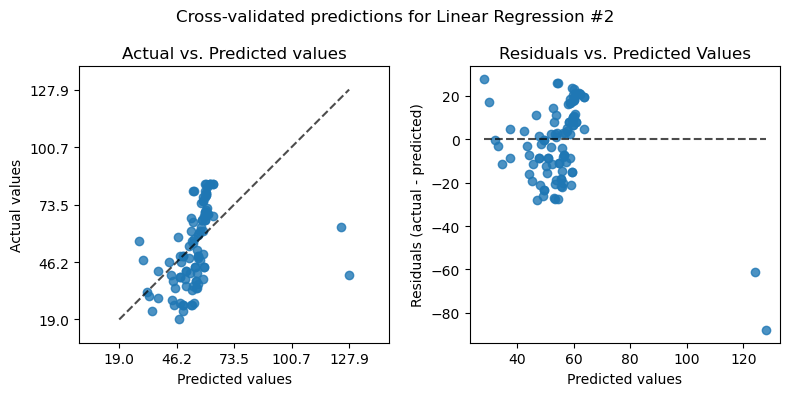

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y_pred_lr_2,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y_pred_lr_2,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for Linear Regression #2")
plt.tight_layout()
plt.show()

#### Lasso #1

In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict

model_lasso = Lasso(alpha=0.5)

y_pred_lasso_1 = cross_val_predict(model_lasso, X_1, y_1, cv=10)

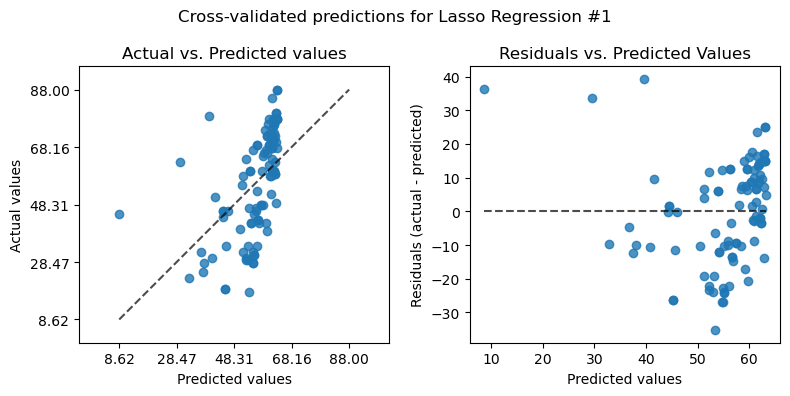

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y_pred_lasso_1,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y_pred_lasso_1,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for Lasso Regression #1")
plt.tight_layout()
plt.show()

In [19]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict

model_lasso = Lasso(alpha=0.5)

y_pred_lasso_2 = cross_val_predict(model_lasso, X_1, y_1, cv=10)

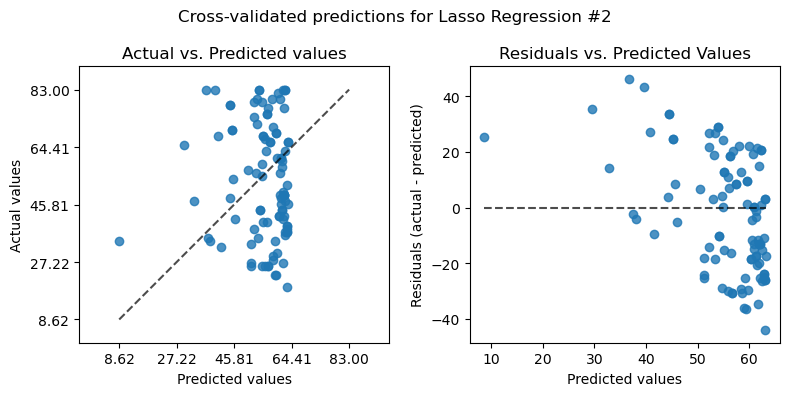

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y_pred_lasso_2,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y_pred_lasso_2,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for Lasso Regression #2")
plt.tight_layout()
plt.show()

#### Support Vector Regressor #1

In [21]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model_svr.fit(X_1, y_1)

y1_pred_svr = cross_val_predict(model_svr, X_1, y_1, cv=10)



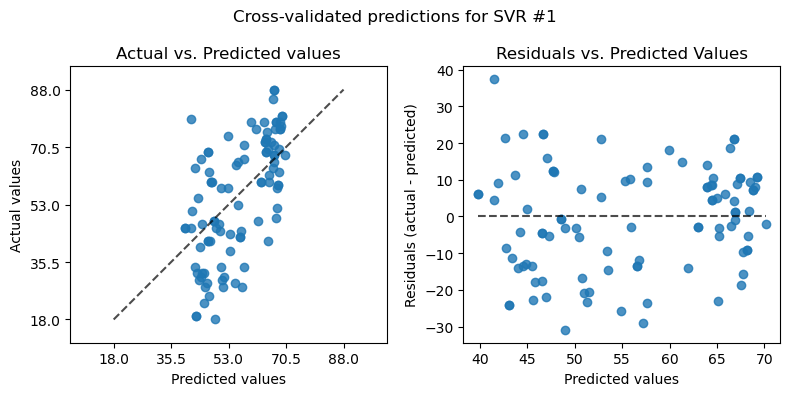

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y1_pred_svr,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y1_pred_svr,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for SVR #1")
plt.tight_layout()
plt.show()

#### Support Vector Regressor #2

In [26]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model_svr.fit(X_2, y_2)

y2_pred_svr = cross_val_predict(model_svr, X_2, y_2, cv=10)
scores = model_svr.score(X_2, y_2)
print(scores)


0.34794297602715796


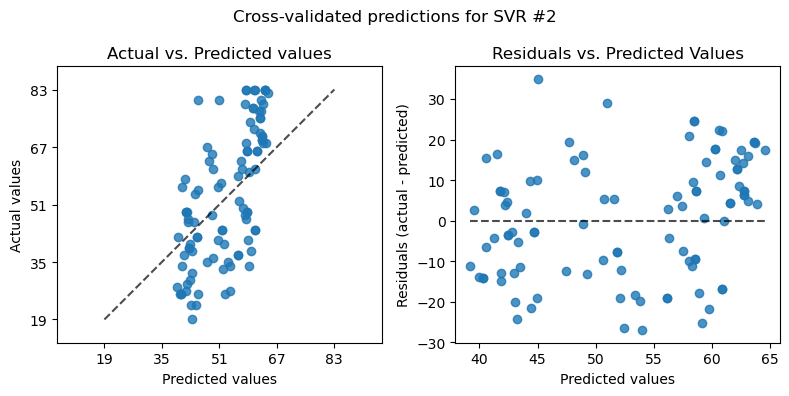

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y2_pred_svr,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_2,
    y_pred=y2_pred_svr,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for SVR #2")
plt.tight_layout()
plt.show()

In [2]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


model_svm = SVR(kernel='linear', C=1, gamma='auto')
model_svm.fit(X_1, y_1)

scores = model_svm.score(X_1, y_1)
print(scores)


NameError: name 'X_1' is not defined

In [167]:
y1_pred_svr = cross_val_predict(model_svm, X_1, y_1, cv=10)

In [173]:
y11 = y1_pred_svr

In [187]:
for i in range(len(y11)):
    if y11[i] < 0:
        y11[i] = 0
              
for j in y11:
    print(j)
    
for i in range(len(y11)):
    if y11[i] > 100:
        y11[i] = 100
              
for j in y11:
    print(j)

58.98850523913398
60.36760399723544
59.36320635723069
62.66340107424303
56.61439083749547
169.48209098214403
51.954263987486506
61.45217833155885
1601.7089606248785
53.190310644452715
49.26310052955642
199.81910851737604
60.98921075323715
56.8521524989058
62.31529745785638
49.930064352696085
44.94446280086532
25.032552252059126
62.09819781826928
54.81147050345435
57.923481179868126
56.54011603677764
54.584593868349934
59.83849531272545
56.277376678307796
54.610777842347765
58.87029617885246
51.69661067659154
46.51977660739913
57.01515436777964
142.7357547194709
55.971159233247185
59.634341655765915
68.07968812953197
48.80168525740021
61.57779985531681
0.0
65.62249139561766
65.74485230590665
50.68710372462385
64.94839127040916
28.802111981953317
65.02195951301121
62.192936715255314
59.68016574955993
6.30595099791401
66.12086421023571
66.04386379900836
57.761993565182024
54.146701967860395
58.75988716497534
58.52501363358908
47.04884069278353
64.22962927683704
65.52765699155145
45.751152

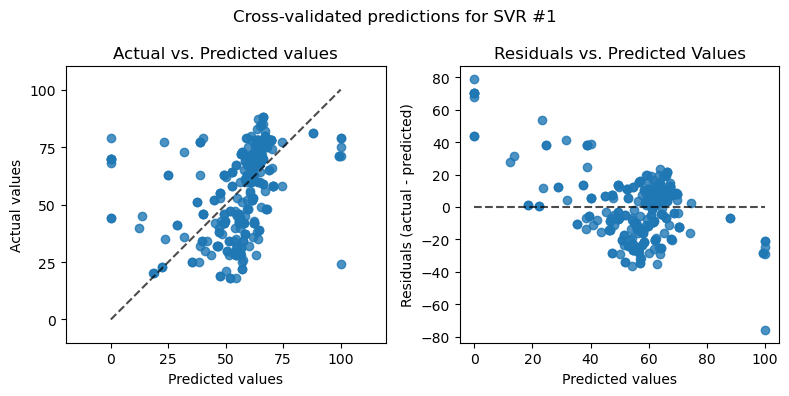

In [188]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y11,
    kind="actual_vs_predicted",
    subsample=300,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_1,
    y_pred=y11,
    kind="residual_vs_predicted",
    subsample=300,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Cross-validated predictions for SVR #1")
plt.tight_layout()
plt.show()

In [16]:
print(model_svm.predict(X_test))

[ 5.15287990e+01  3.88290250e+01  5.73029520e+01  5.83574203e+01
  4.83191882e+01  5.74820103e+01  4.48828309e+01  6.36295448e+01
  6.48287032e+01  6.21166263e+01 -6.15591697e+03  5.76391364e+01
  5.39522724e+01  5.74263035e+01  6.30220701e+01  3.72818729e+01
  6.54728004e+01  5.61643195e+01  5.85465762e+01  6.13599477e+01
  1.72439532e+01  6.12874279e+01  4.17609938e+01  6.04851564e+01
  6.57053244e+01  5.19718851e+01  5.52793989e+01  6.54056506e+01
  6.44410119e+01  4.23063565e+01  4.93741827e+01  4.36231390e+01
  5.40440268e+01  6.56646507e+01  6.53740938e+01  5.57830839e+01
  6.07276750e+01  5.89589440e+01  3.01758055e+01  5.15788425e+01
  4.94549154e+01  6.30057717e+01  6.47052863e+01  5.98489742e+01
  6.41933188e+01  5.83355357e+01  6.50990331e+01  6.55664335e+01
  6.13039907e+01  6.21513982e+01  6.17887286e+01  5.77128318e+01
  6.24652255e+01  4.96697208e+01  5.52647788e+01  6.39497790e+01
  5.07445227e+01  2.69329905e+01  6.19486711e+01  6.48375734e+01
  5.44745607e+01  6.17346

In [ ]:
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import numpy as np

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Choose the model
model = svm.SVR()
age_list = meta_data['age']

# Fit the model
model.fit(X_scaled, age_list)

model.predict(y)

#### Visualizing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

## Part B: Image-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the set of MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the MNI atlas (compare slide 99 of the Segmentation lecture).

Because the grey matter maps are spatially normalised, voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large, there would be a very large number of features to deal with. A dimensionality reduction using PCA needs to be performed before training a suitable regressor on the low-dimensional feature representation obtained with PCA. It might also be beneficial to apply some pre-processing before running PCA, which should be explored. The implemented pipeline should be evaluated using cross-validation using the same data splits as in part A, so the two approaches can be directly compared.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis, such as training a regressor where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation that had been applied to the maps.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed, before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* Check out tutorial 1. You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation.

In [137]:
import glob
import numpy as np
import SimpleITK as sitk

def kafka_(output_dir, img):
    for i, map in enumerate(img):
        outputImageFileName = output_dir + maps_filenames[i].split('/')[-1]
        map_image = sitk.GetImageFromArray(map)
        sitk.WriteImage(map_image, outputImageFileName)
        print(f"Preprocessed map {maps_filenames[i]} saved as {outputImageFileName}")

def preprocess_gray_matter_maps(gray_matter_maps, smoothing_sigma=2, downsampling_factor=2):
    preprocessed_maps = []

    for gray_matter_map in gray_matter_maps:
        
        img = sitk.ReadImage(gray_matter_map)
        
        smoothed_map = sitk.SmoothingRecursiveGaussian(img, smoothing_sigma)

        # Downsample the smoothed map
        downsampled_map = sitk.Resample(smoothed_map, size=[int(sz / downsampling_factor) for sz in smoothed_map.GetSize()])

        # Convert the downsampled map to a NumPy array
        downsampled_array = sitk.GetArrayFromImage(downsampled_map)

        preprocessed_maps.append(downsampled_array)

    return np.array(preprocessed_maps)

data_dir = '/home/burakk/Projects/itu-mic/data/'

maps_dir = data_dir + "graymaps/" 
maps_filenames = sorted(glob.glob(maps_dir + '*.nii.gz'))

maps_output_dir = data_dir + "o_graymaps/"

gray_pro = preprocess_gray_matter_maps(maps_filenames, smoothing_sigma=2, downsampling_factor=2)

kafka_(maps_output_dir, gray_pro)


Preprocessed map /home/burakk/Projects/itu-mic/data/graymaps/wc1sub-CC110033_T1w_rigid_to_mni.nii.gz saved as /home/burakk/Projects/itu-mic/data/o_graymaps/wc1sub-CC110033_T1w_rigid_to_mni.nii.gz
Preprocessed map /home/burakk/Projects/itu-mic/data/graymaps/wc1sub-CC110037_T1w_rigid_to_mni.nii.gz saved as /home/burakk/Projects/itu-mic/data/o_graymaps/wc1sub-CC110037_T1w_rigid_to_mni.nii.gz
Preprocessed map /home/burakk/Projects/itu-mic/data/graymaps/wc1sub-CC110045_T1w_rigid_to_mni.nii.gz saved as /home/burakk/Projects/itu-mic/data/o_graymaps/wc1sub-CC110045_T1w_rigid_to_mni.nii.gz
Preprocessed map /home/burakk/Projects/itu-mic/data/graymaps/wc1sub-CC110056_T1w_rigid_to_mni.nii.gz saved as /home/burakk/Projects/itu-mic/data/o_graymaps/wc1sub-CC110056_T1w_rigid_to_mni.nii.gz
Preprocessed map /home/burakk/Projects/itu-mic/data/graymaps/wc1sub-CC110062_T1w_rigid_to_mni.nii.gz saved as /home/burakk/Projects/itu-mic/data/o_graymaps/wc1sub-CC110062_T1w_rigid_to_mni.nii.gz
Preprocessed map /ho

##### Display a random sample

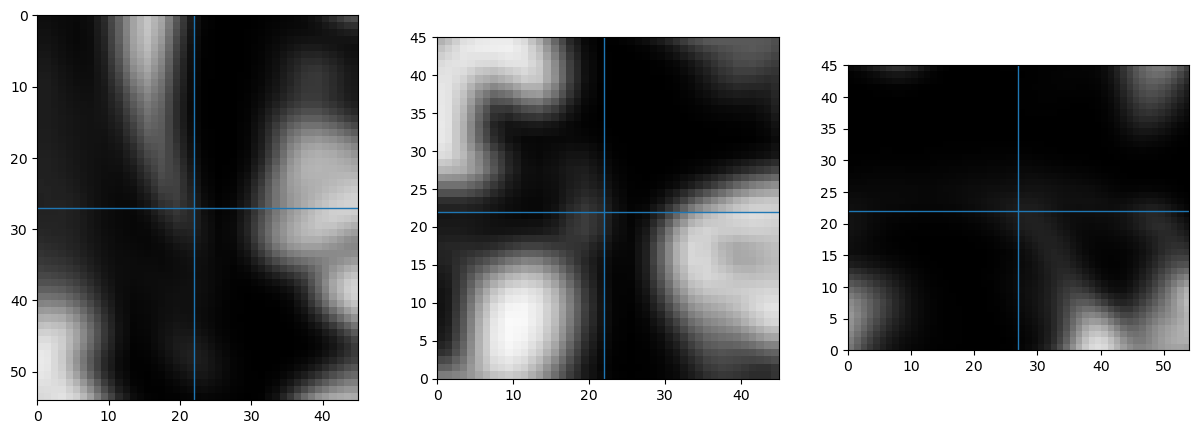

In [15]:
data_dir = '/home/burakk/Projects/itu-mic/data/'

maps_output_dir = data_dir + "o_graymaps/"
maps_filenames = sorted(glob.glob(maps_output_dir + '*.nii.gz'))

random_state = 42

img = sitk.ReadImage(maps_filenames[random_state])

display_image(img)



### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance that needs to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

##### Reading the training data

In [17]:
import glob
import numpy as np
import SimpleITK as sitk

data_dir = '/home/burakk/Projects/itu-mic/data/'

maps_output_dir = data_dir + "o_graymaps/"
maps_filenames = sorted(glob.glob(maps_output_dir + '*.nii.gz'))

M = []

for i in range(len(maps_filenames)):
    img = sitk.ReadImage(maps_filenames[i])
    M.append(img)
    
# Convert the list of SimpleITK images to a NumPy array
numpy_array = np.array([sitk.GetArrayFromImage(image) for image in M])


##### PCA

In [21]:
from sklearn.decomposition import PCA

flattened_array = numpy_array.reshape(numpy_array.shape[0], -1)

# Step 1: Fitting PCA to the training data
pca = PCA(n_components=0.95)  # Preserve 95% of the variance

# Fit PCA on the training data
pca.fit(flattened_array)

# Step 2: Applying dimensionality reduction to both training and testing data
M_train_reduced = pca.transform(flattened_array)

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for approach A so results can be directly compared.

Try using at least two different regression methods.

*Note:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

#### Linear Models

In [22]:

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Linear regression
model_lr_21 = LinearRegression().fit(X, y)
y_pred_lr_21 = cross_val_predict(model_lr_21, X, y, cv=2)
y_scores_lr_21 = cross_val_score(model_lr_21, X, y, cv=2)

print("Scores:", y_scores_lr_11.mean())

# Lasso Regression with alpha = 0.01
model_lasso_21 = Lasso(alpha=0.01).fit(X, y)
y_pred_lasso_21 = cross_val_predict(model_lasso_21, M_train_reduced, y, cv=2)
y_scores_lasso_21 = cross_val_score(model_lasso_21, M_train_reduced, y, cv=2)

print("Scores:", y_scores_lasso_21.mean())

# Lasso Regression with alpha = 0.1
model_lasso_22 = Lasso(alpha=0.1).fit(X, y)
y_pred_lasso_22 = cross_val_predict(model_lasso_22, M_train_reduced, y, cv=2)
y_scores_lasso_22 = cross_val_score(model_lasso_22, M_train_reduced, y, cv=2)

print("Scores:", y_scores_lasso_22.mean())

# Ridge Regression with alpha = 0.01
model_ridge_21 = Ridge(alpha=0.01).fit(X, y)
y_pred_ridge_21 = cross_val_predict(model_ridge_21, M_train_reduced, y, cv=2)
y_scores_ridge_21 = cross_val_score(model_ridge_21, M_train_reduced, y, cv=2)

print("Scores:", y_scores_ridge_21.mean())

# Ridge Regression with alpha = 0.1
model_ridge_22 = Lasso(alpha=0.1).fit(X, y)
y_pred_ridge_22 = cross_val_predict(model_ridge_22, M_train_reduced, y, cv=2)
y_scores_ridge_22 = cross_val_score(model_ridge_22, M_train_reduced, y, cv=2)

print("Scores:", y_scores_ridge_22.mean())


Scores: -7.89091988953661
Scores: -1.207556721618698
Scores: -1.3418405180531785
Scores: -1.2297527672757276
Scores: -1.3418405180531785


In [ ]:
vs_plots(y_pred=y_pred_lr_21, ModelName="Linear Regression")
vs_plots(y_pred=y_pred_lasso_21, ModelName="Lasso Regression (alpha=0.01)")
vs_plots(y_pred=y_pred_lasso_22, ModelName="Lasso Regression (alpha=0.1)")
vs_plots(y_pred=y_pred_ridge_21, ModelName="Ridge Regression (alpha=0.01)")
vs_plots(y_pred=y_pred_ridge_22, ModelName="Ridge Regression (alpha=0.1)")

#### Support Vector Regressor

In [25]:
from sklearn.svm import SVR

model_svr_21 = SVR(kernel='linear', C=1, gamma='auto').fit(X, y)
y_pred_svr_21 = cross_val_predict(model_svr_21, M_train_reduced, y, cv=2)
y_scores_svr_21 = cross_val_score(model_svr_21, M_train_reduced, y, cv=2)

print("Scores:", y_scores_svr_21.mean())

#### Plots

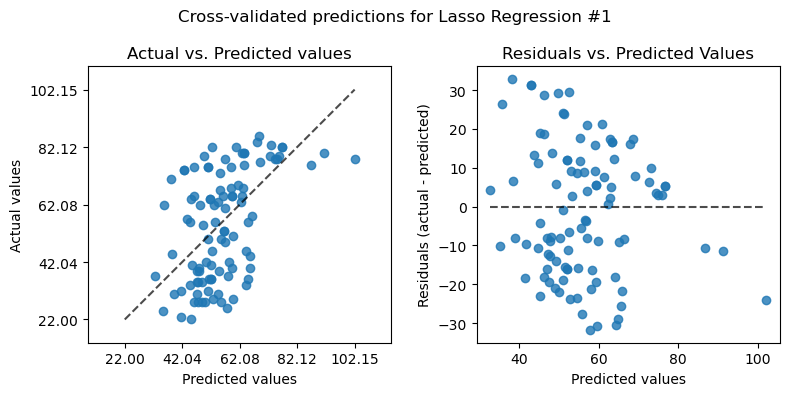

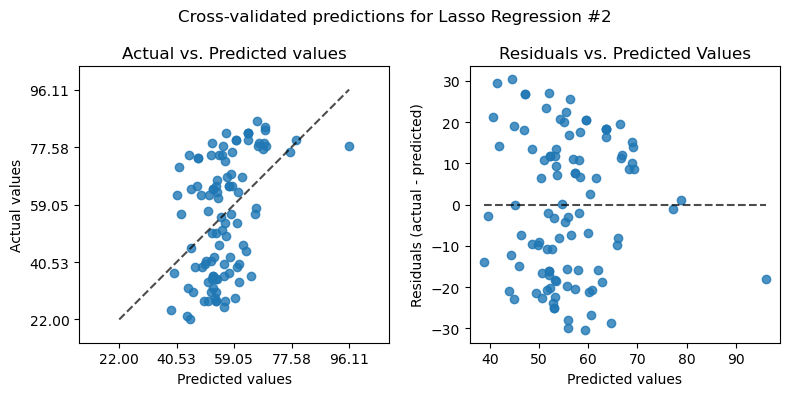

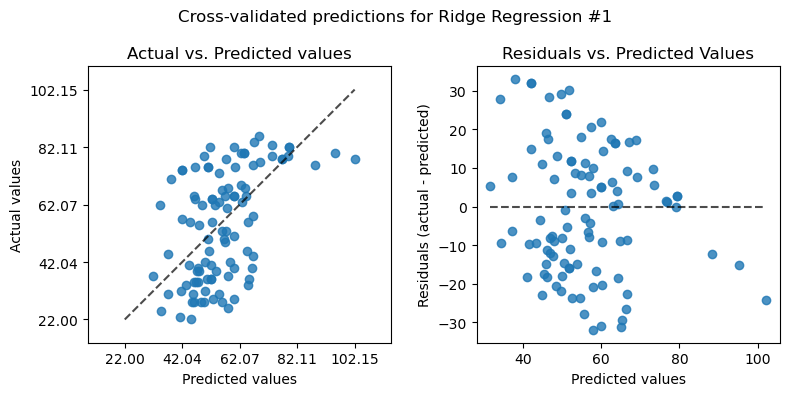

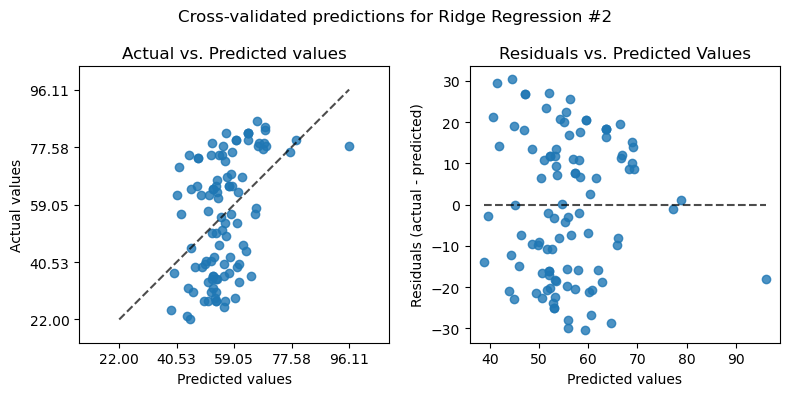

NameError: name 'y_pred_svr_21' is not defined

In [24]:
vs_plots(y_pred=y_pred_svr_21, ModelName="SVR")